In [1]:
# Python 3.7 built-in
import datetime
import itertools
import multiprocessing
import operator
import os
import pathlib
import pandas
import random
import re
import shutil
import subprocess
import time
import uuid

# additional dependencies
from Bio import SeqIO  # pip3 install biopython
import tqdm            # pip3 install tqdm

In [2]:
# parameter configuration
results_directory = 'results'

experiment_name = 'N1_Normal'
all_denovo_file = 'data/N1_Normal/N1_Normal_all_de_novo.csv'
db_matched_file = 'data/N1_Normal/N1_Normal_DB-matched_peptides.csv'
reference_proteome_file = 'data/SPHu.fasta'

min_peptide_length = 7
max_peptide_length = 25
alc_score_cutoff = 50
max_fusion_distance = 40
number_of_cores = multiprocessing.cpu_count()

include_PTMs = True     # if True, converts C(+57.02)FKHSGTGM(+15.99)VHR to CFKHSGTGMVHR; else, skips the row

# create working directory if it does not exist; all output will be stored here
results_path = results_directory + os.sep + experiment_name
pathlib.Path(results_path).mkdir(parents=True, exist_ok=True)

ref_db = {seq.name: str(seq.seq) for seq in SeqIO.parse(reference_proteome_file, 'fasta')}


In [3]:
# classes to structure the Peptides data for scanning purposes
class Peptide:
    def __init__(self, name, scanID, score):
        self.name = name
        self.scanID = scanID
        self.score = score
        self.unique_identifier = str(uuid.uuid4())
        self.fragments = []


class FragmentPair:
    def __init__(self, pair):
        self.pair = pair
        self.matchPairs = []


class Match:
    def __init__(self, name, start, stop, number):
        self.name = name
        self.start = start
        self.stop = stop
        self.ORF = number


class FusedPeptide:
    def __init__(self):
        self.name = None
        
        self.fragment_1 = None
        self.fragment_1_start = None
        self.fragment_1_stop = None
        self.match_1_name = None
        self.match_1_start = None
        self.match_1_stop = None
        
        self.fragment_2 = None
        self.fragment_2_start = None
        self.fragment_2_stop = None
        self.match_2_name = None
        self.match_2_start = None
        self.match_2_stop = None
        
        self.cis_distance_12 = 'N/A'

In [4]:
# methods for peptide fusion analysis and running
def _create_combinations_with_isoleucines(peptide):
    """
    Performs all possible combinations of string reassignment of L to I.
    """
    count = peptide.count('L')
    product = [''.join(seq) for seq in itertools.product("01", repeat=count)]
    positions = [pos for pos, char in enumerate(peptide) if char == 'L']
    peptides = []
    for combo in product:
        partitioned_peptide = list(peptide)
        for pos, item in enumerate(positions):
            if combo[pos] == '1':
                partitioned_peptide[item] = 'I'
        peptides.append(''.join(partitioned_peptide))
    return peptides


def _fragment_peptide(peptide):
    """
    Fragments the provided peptide according to the length requirement.
    
    Returns a list of fragment pairs, in order, sorted by full length peptide fragment first.
    """
    fragments = []
    
    # generate I/L variants
    IL_variants = _create_combinations_with_isoleucines(peptide.name)
    for fragment in IL_variants:
        fragments.append(FragmentPair(['', fragment]))
    
    # generate spliced peptide fragments
    for IL_variant in IL_variants:
        for position in range(2, len(IL_variant)-1):
            fragments.append(FragmentPair([IL_variant[:position], IL_variant[position:]]))
    
    # sort fragments, longest fragments (full length) first - necessary for excluding them from splice searches if they match database in full
    fragments.sort(key=lambda x: len(x.pair[-1]), reverse=True)
    
    return fragments


def _search_for_fragment_in_protein_by_splitting_ORFs(peptide, references_data, max_search_distance=40):
    """
    Creates the reference search space for the sequence. Updates the Peptide
    object's Fragment objects with any Match objects it finds.
    
    First fragment to be searched is full length peptide itself - which means if matched,
    the search will stop before next fragment set gets a chance to be matched.
    
    Returns the updated Peptide.
    """
    full_length_match_found = False
    for fragment in peptide.fragments:
        # stop looking for matches if full length fragment match found
        if full_length_match_found:
            break
        
        for protein_name, sequence in references_data.items():
            sequence = sequence.strip('X*')
            
            distance = 0
            if 'X' in sequence:
                splitter = 'X'
            else:
                splitter = '*'
            for number, ORF in enumerate(sequence.split(splitter)):
                
                # determine the side which has the big fragment (defined in fragment_peptide method)
                if len(fragment.pair[1]) < len(fragment.pair[0]):
                    large_fragment = fragment.pair[0]
                    small_fragment = fragment.pair[1]
                else:
                    large_fragment = fragment.pair[1]
                    small_fragment = fragment.pair[0]
                
                for match_data_large in re.finditer(large_fragment, ORF):
                    
                    match_large = Match(protein_name, match_data_large.start()+distance, match_data_large.end()-1+distance, number)
                    
                    # determine the search space start for small fragment matching
                    starting_position = match_data_large.start()-(max_search_distance+len(small_fragment))
                    if starting_position < 0:
                        starting_position = 0
                    
                    # full length matches
                    if len(small_fragment) == 0:
                        full_length_match_found = True
                        fragment.matchPairs.append(['N/A', match_large])
                        continue
                    
                    for match_data_small in re.finditer(small_fragment, ORF[starting_position:match_data_large.end()+1+max_search_distance+len(small_fragment)]):
                        
                        match_small = Match(protein_name, starting_position+match_data_small.start()+distance, starting_position+match_data_small.end()-1+distance, number)
                        
                        # discard results if large fragment match overlaps with small fragment match
                        if match_small.stop >= match_large.start and match_small.start <= match_large.stop:
                            continue
                        
                        if len(fragment.pair[1]) < len(fragment.pair[0]):
                            fragment.matchPairs.append([match_large, match_small])
                        else:
                            fragment.matchPairs.append([match_small, match_large])
                    
                distance += len(ORF)+1
    return peptide


def create_fused_peptide(f, fragment_1, fragment_2, match_1, match_2, peptide):
    """
    Writes out fused peptide info.
    """
    # create fused peptide info
    fused_peptide = FusedPeptide()
    fused_peptide.name = peptide.name
    
    # fused peptide match
    if fragment_1:
        fused_peptide.fragment_1 = fragment_1
        fused_peptide.match_1_name = match_1.name
        fused_peptide.match_1_start = match_1.start
        fused_peptide.match_1_stop = match_1.stop
        
        fused_peptide.fragment_2 = fragment_2
        fused_peptide.match_2_name = match_2.name
        fused_peptide.match_2_start = match_2.start
        fused_peptide.match_2_stop = match_2.stop
        
        if match_1.stop < match_2.start:
            if match_1.stop+1 == match_2.start:
                return 0    # skip output if fusion is not sensible
            fused_peptide.cis_distance_12 = match_2.start - match_1.stop - 1
        else:
            fused_peptide.cis_distance_12 = match_1.start - match_2.stop - 1
    
    # full length peptide match
    else:
        fused_peptide.fragment_1 = fragment_2
        fused_peptide.match_1_name = match_2.name
        fused_peptide.match_1_start = match_2.start
        fused_peptide.match_1_stop = match_2.stop
        fused_peptide.cis_distance_12 = 'N/A'
        
    write_temp_file(f, fused_peptide, peptide)


def write_temp_file(f, fused_peptide, peptide, unmatched=False):
    """
    Write a temporary text file for later.
    """
    if unmatched:
        f.write('%s,%d,%s,%s,%s,%s,%s,%s,%s,%s,%d,%d,%s,%s\n' %
                (fused_peptide,
                len(fused_peptide),
                'N/A',
                'N/A',
                'N/A',
                'N/A',
                'N/A',
                'N/A',
                'N/A',
                'N/A',
                peptide.scanID,
                peptide.score,
                'de novo non-matched',
                peptide.unique_identifier))
        return
    
    if fused_peptide.cis_distance_12 != 'N/A':
        f.write('%s,%d,%s,%s,%d,%d,%s,%s,%d,%d,%d,%d,%s,%s\n' %
                (fused_peptide.name,
                len(fused_peptide.name),
                fused_peptide.match_1_name,
                fused_peptide.fragment_1,
                fused_peptide.match_1_start+1,
                fused_peptide.match_1_stop+1,
                str(fused_peptide.cis_distance_12),
                fused_peptide.fragment_2,
                fused_peptide.match_2_start+1,
                fused_peptide.match_2_stop+1,
                peptide.scanID,
                peptide.score,
                'de novo matched and fused',
                peptide.unique_identifier))
    else:
        f.write('%s,%d,%s,%s,%d,%d,%s,%s,%s,%s,%d,%d,%s,%s\n' %
                (fused_peptide.name,
                len(fused_peptide.name),
                fused_peptide.match_1_name,
                fused_peptide.fragment_1,
                fused_peptide.match_1_start+1,
                fused_peptide.match_1_stop+1,
                'N/A',
                'N/A',
                'N/A',
                'N/A',
                peptide.scanID,
                peptide.score,
                'de novo DB-matched',
                peptide.unique_identifier))

        
def find_peptide_fusions(experiment, peptide, n_peptide, directory, references_data, max_search_distance):
    """
    Finds peptides that could be fused and outputs their matches.
    """
    peptide.fragments = _fragment_peptide(peptide)
    
    # find fragments in experimental data
    peptide = _search_for_fragment_in_protein_by_splitting_ORFs(peptide, references_data, max_search_distance)
    
    f_name = '%s%s_%d.txt' % (directory, experiment, n_peptide)
    f = open(f_name, 'w')
    
    # outputting the fusions
    matched = False
    for fragment in peptide.fragments:
        for match_pair in fragment.matchPairs:
            matched = True
            create_fused_peptide(f, fragment.pair[0], fragment.pair[1], match_pair[0], match_pair[1], peptide)
    
    # store the peptides that were not matched as fused or to the reference proteome
    if not matched:
        write_temp_file(f, peptide.name, peptide, unmatched=True)
    f.close()


def running_python_jobs_count():
    return len([i for i in subprocess.check_output(['ps', 'uax']).splitlines() if 'python' in str(i) and 'R' in str(i)])


In [5]:
# read in peptide fusion candidates and eliminate duplicate rows
df_fused_peptide_candidates = pandas.read_csv(results_path + os.sep + 'Fused_peptide_candidates.csv',
                                              usecols=['Peptide', 'Scan', 'ALC (%)']).drop_duplicates()

# generate peptide datastructure
fused_peptide_candidates = [Peptide(*data[1].values) for data in df_fused_peptide_candidates.iterrows()]
fused_peptide_candidates = fused_peptide_candidates[:1000] # TESTING: limiting here for test purposes


In [6]:
# perform peptide fusion; if recent files exist, prevent override unless multithreaded_temp_files are deleted
temp_files_path = results_directory + os.sep + experiment_name + os.sep + 'multithreaded_temp_files' + os.sep
pathlib.Path(temp_files_path).mkdir(parents=True, exist_ok=True)

# setup jobs
jobs = []
for n_peptide, peptide in enumerate(fused_peptide_candidates):
    job = multiprocessing.Process(target=find_peptide_fusions,
                                  args=(experiment_name,
                                        peptide,
                                        n_peptide,
                                        temp_files_path,
                                        ref_db,
                                        max_fusion_distance))
    jobs.append(job)

# run jobs
progress_bar = tqdm.tqdm_notebook(total=len(jobs))
while len(jobs) > 0:
    if running_python_jobs_count() <= number_of_cores:
        job = jobs.pop()
        job.start()
        progress_bar.update(1)
progress_bar.close() # Note: this will complete just before the final peptides have finished scanning


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [7]:
# assemble all results into a single file
header = ['Peptide', 'Length', 'ProteinID',
          'Fragment 1', 'Match 1 Start', 'Match 1 Stop', 'Cis Distance',
          'Fragment 2', 'Match 2 Start', 'Match 2 Stop',
          'Scan', 'ALCScore', 'Origin', 'ParentID']

df = pandas.DataFrame(columns=header)
for f in os.listdir(temp_files_path):
    df = pandas.concat([df, pandas.read_csv(temp_files_path + os.sep + f, names=header)], axis=0)

try:
    shutil.rmtree(temp_files_path)
except:
    print('Directory already removed or no permissions to delete.')

df = df.fillna('N/A')


In [8]:
def get_direction(start, end, origin):
    if origin == 'de novo matched and fused':
        if start < end:
            return 'Forward'
        else:
            return 'Reverse'
    else:
        return 'N/A'


def get_fused_fragments(direction, fragment_1, fragment_2):
    if direction != 'N/A':
        return fragment_1 + fragment_2
    else:
        return 'N/A'


df['Direction'] = df.apply(lambda row: get_direction(row['Match 1 Start'], row['Match 2 Start'], row['Origin']), axis=1)
df['Fused Peptide'] = df.apply(lambda row: get_fused_fragments(row['Direction'], row['Fragment 1'], row['Fragment 2']), axis=1)
df.to_csv(results_path + os.sep + 'Matched_all.csv', index=False)
df[df['Direction'] == 'Forward'].to_csv(results_path + os.sep + 'Matched_denovo_Fused_Forward.csv', index=False)
df[df['Direction'] == 'Reverse'].to_csv(results_path + os.sep + 'Matched_denovo_Fused_Reverse.csv', index=False)
df[df['Origin'] == 'de novo DB-matched'].to_csv(results_path + os.sep + 'Matched_denovo_DB-matched.csv', index=False)
df[df['Origin'] == 'de novo non-matched'].to_csv(results_path + os.sep + 'Unmatched_denovo.csv', index=False)

df


,Peptide,Length,ProteinID,Fragment 1,Match 1 Start,Match 1 Stop,Cis Distance,Fragment 2,Match 2 Start,Match 2 Stop,Scan,ALCScore,Origin,ParentID,Direction,Fused Peptide
0,STTAAVQDHAVVSGR,15,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,4044,51,de novo non-matched,16f6a52a-60e9-47f5-a802-141f80560b1a,N/A,N/A
0,KTDEKANGSPGLK,13,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,4953,57,de novo non-matched,fe7a0a94-c042-4844-a836-78a13bd0304d,N/A,N/A
0,LKQLEEGATKK,11,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,4911,69,de novo non-matched,c90769f1-b4df-42f7-bacc-4db8ebd5d134,N/A,N/A
0,HRPPHDEWLQAR,12,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,5165,65,de novo non-matched,58d31a21-2934-4567-9a56-c51c1c100fc9,N/A,N/A
0,KASQTFGLGCK,11,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,5025,62,de novo non-matched,af7a866a-4771-41f3-bd96-ebea74386b99,N/A,N/A
0,KCSVNAARVGK,11,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,5156,51,de novo non-matched,4a5f56f9-3fdf-4b2a-9325-c69e5759fcb0,N/A,N/A
0,VKENFDAKR,9,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,5239,72,de novo non-matched,792d05dd-e15c-498a-bcf8-3915f63b4335,N/A,N/A
0,KHKVESQGAGGHR,13,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,4996,59,de novo non-matched,f02cf054-c3df-4925-8789-0da9b6a6ee66,N/A,N/A
0,KFCKDVVSGGKK,12,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,5006,74,de novo non-matched,fa81f340-da7f-44a7-bcbb-08c736d586ce,N/A,N/A
0,KQLTTGGKLKPHR,13,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,4166,69,de novo non-matched,becd44ce-484b-4809-a278-33577b248d91,N/A,N/A


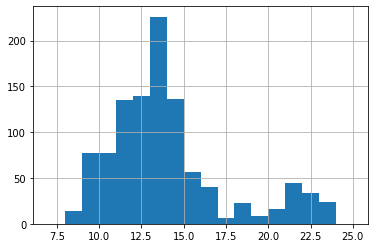

In [19]:
df[df['Origin'] == 'de novo non-matched']['Length'].hist(bins=range(7, 26))
